In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install --upgrade ipywidgets
# !jupyter nbextension enable --py widgetsnbextension
# !jupyter nbextension install --py widgetsnbextension

In [ ]:
# !unzip /content/drive/MyDrive/DLS/datasets/journey-springfield.zip -d /content/drive/MyDrive/DLS/datasets/journey-springfield1

# Imports

In [ ]:
!pip install torch-summary

In [ ]:
import pickle
import numpy as np
from skimage import io

import time
from tqdm import tqdm, tqdm_notebook, trange
from tqdm.autonotebook import tqdm, trange
from PIL import Image
from pathlib import Path
from torchvision import datasets, models, transforms
import torchvision.transforms as tfs
from torchsummary import summary
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler

from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

<ipython-input-6-c0d6e3a8bb3c>:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


CUDA is available!  Training on GPU ...


In [ ]:
import PIL
print(PIL.__version__)

9.4.0


In [ ]:
!nvidia-smi


Wed Jun 26 16:33:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0              48W / 400W |      5MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
# pip install --upgrade tqdm ipywidgets jupyter


In [ ]:
for i in tqdm(range(100)):
    time.sleep(0.1)


  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Custom wrapper

In [ ]:
#определим директории с тренировочными и тестовыми файлами
train_dir = Path('/content/drive/MyDrive/DLS/datasets/journey-springfield1/train')
test_dir = Path('/content/drive/MyDrive/DLS/datasets/journey-springfield1/testset')

In [ ]:
train_dir

PosixPath('/content/drive/MyDrive/DLS/datasets/journey-springfield1/train')

In [ ]:
train_files = sorted(list(train_dir.rglob('*.jpg')))
test_files = sorted(list(test_dir.rglob('*.jpg')))



In [ ]:
from sklearn.model_selection import train_test_split


train_files, val_files = train_test_split(train_files)
train_labels = [path.parent.name for path in train_files]
val_labels = [path.parent.name for path in val_files]

In [ ]:
len(train_files), len(val_files)

(4455, 1486)

In [ ]:
len(train_labels), len(val_labels)

(4455, 1486)

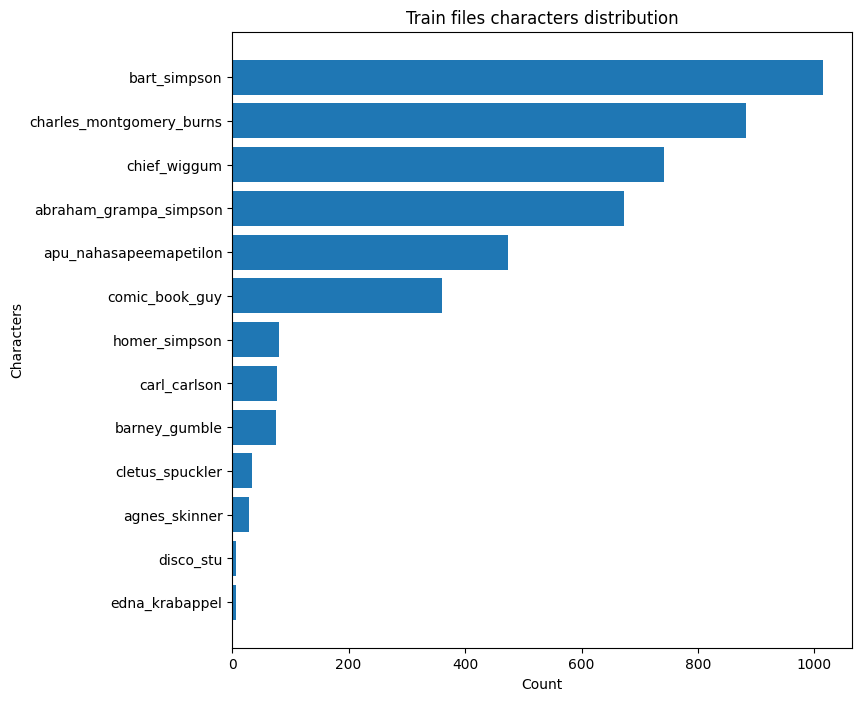

In [ ]:
counts = pd.Series(train_labels).value_counts()

plt.figure(figsize=(8,8))
plt.barh(counts.keys()[::-1], counts.sort_values(ascending=True))
plt.title('Train files characters distribution')
plt.xlabel('Count')
plt.ylabel('Characters')
plt.show();

In [ ]:
modes = ['train', 'test', 'val']

class Simpsons(Dataset):
    def __init__(self, files, mode):
        self.files = files
        self.mode = mode
        self.len_ = len(self.files)

        if self.mode not in modes:
            print(f'{self.mode} incorrect. Use actual in {modes}.')
            raise NameError

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('le.pickle', 'wb') as dumped_file:
                pickle.dump(self.label_encoder, dumped_file)

    def __len__(self):
        return self.len_

    def load_img(self, file):
        img = Image.open(file)
        img.load()
        return img

    def __getitem__(self, idx):
        if self.mode == 'test' or self.mode == 'val':
            transform = tfs.Compose([
                tfs.Resize(size=(224,224), antialias=True),
                tfs.Lambda(lambda x: np.array(x, dtype='float32') / 255),
                tfs.ToTensor(),
                tfs.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        elif self.mode == 'train':
            augmentation = tfs.RandomChoice([
                tfs.Compose([
                    tfs.Resize(size=300, max_size=301),
                    tfs.CenterCrop(size=300),
                    tfs.RandomCrop(250)
                ]),
                tfs.RandomRotation(degrees=(-25,25)),
                tfs.RandomHorizontalFlip(p=1)
            ])
            transform = tfs.Compose([
                augmentation,
                tfs.Resize(size=(224,224), antialias=True),
                tfs.Lambda(lambda x: np.array(x, dtype='float32') / 255),
                tfs.ToTensor(),
                tfs.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

        file = self.files[idx]
        x = self.load_img(file)
        x = transform(x)

        if self.mode == 'test':
            return x
        else:
            label = self.labels[idx]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x,y

In [ ]:
train_dataset = Simpsons(train_files, mode='train')
test_dataset = Simpsons(test_files, mode='test')
val_dataset = Simpsons(val_files, mode='val')

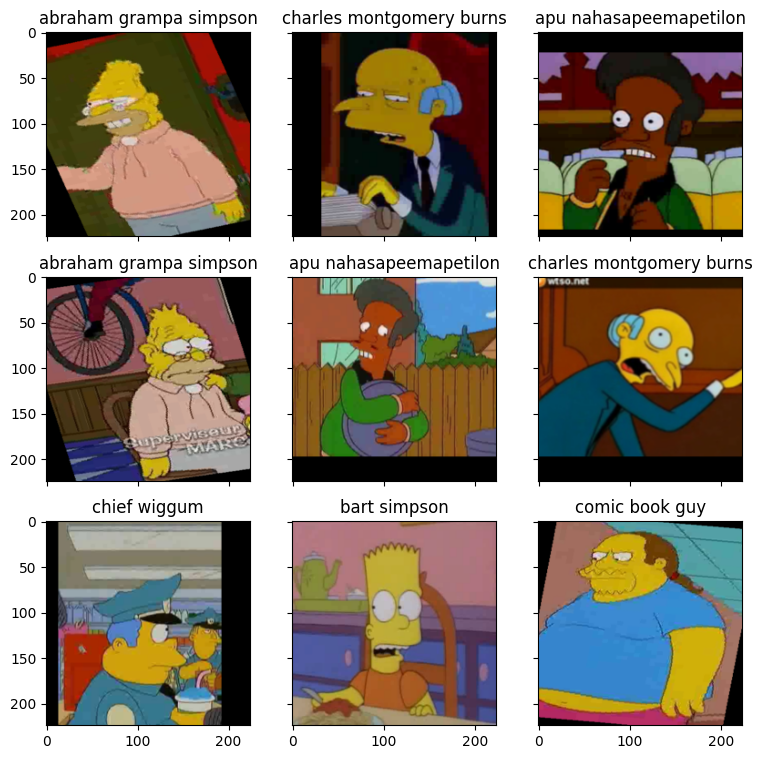

In [ ]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
fig, ax = plt.subplots(figsize=(9,9), sharey=True, sharex=True,
                       nrows=3, ncols=3)

for figx in ax.ravel():
    random_character = np.array(np.random.uniform(len(train_dataset)), dtype='int').item()
    img, label = train_dataset[random_character]
    img = img.permute(1,2,0)
    img = img * std + mean
    img = np.clip(img, 0, 1)
    figx.set_title(" ".join(train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    figx.imshow(img)

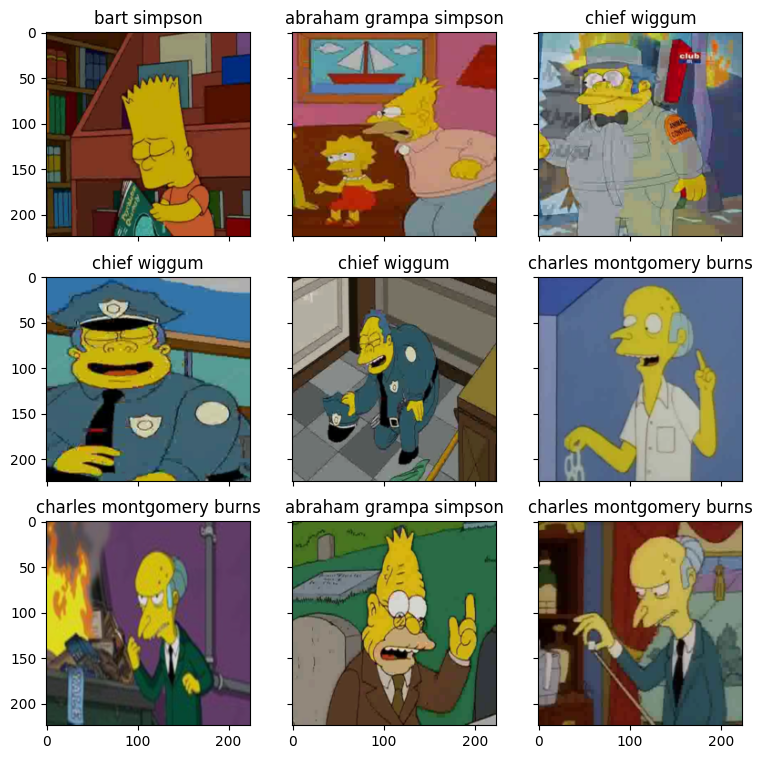

In [ ]:

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
fig, ax = plt.subplots(figsize=(9,9), sharey=True, sharex=True,
                       nrows=3, ncols=3)


for figx in ax.ravel():
    random_character = np.array(np.random.uniform(len(val_dataset)), dtype='int').item()
    img, label = val_dataset[random_character]
    img = img.permute(1,2,0)
    img = img * std + mean
    img = np.clip(img, 0, 1)
    figx.set_title(" ".join(val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    figx.imshow(img)

# Normalizing

In [ ]:
count_weights = {k: 1/v for k,v in counts.items()}
sample_weights = len(train_files) * [0]
sample_weights = [count_weights[label] for label in train_dataset.labels]

In [ ]:
N = counts.max() * len(count_weights)
N = int(N)

In [ ]:
from torch.utils.data import WeightedRandomSampler

train_sampler = WeightedRandomSampler(sample_weights, num_samples=N, replacement=True)
train_dataloader = DataLoader(train_dataset, batch_size=128, sampler=train_sampler, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=128, num_workers=2)

In [ ]:
# from collections import Counter
# count = Counter()
# for data, labels in tqdm(train_dataloader):
#     count += Counter(labels.tolist())

# print(count)

In [ ]:
# for _ in range(10):
#     inputs, targets = next(iter(train_dataloader))


#     # Преобразование тензоров PyTorch в массивы numpy
#     inputs_np = inputs.numpy()
#     targets_np = targets.numpy()


#     plt.imshow(np.transpose(inputs_np[0], (1, 2, 0)))
#     plt.title(f'Label: {targets_np[0]}')
#     plt.show()

In [ ]:
dataloader = {'train': train_dataloader, 'val':val_dataloader}

In [ ]:
dataset_sizes = {'train':len(train_dataset), 'val':len(val_dataset)}

# Train functions

In [ ]:
import copy

def train_loop(model, criterion, optimizer, scheduler, dataloader, dataset_sizes, device, num_epoch=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    losses = {'train':[], 'val':[]}

    pbar = trange(num_epoch, desc='Epoch')

    for epoch in pbar:

        for mode in ['train', 'val']:
            if mode == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for data in tqdm(dataloader[mode], leave=False, desc=f'{mode}, iter:'):
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(mode == 'train'):
                    outputs = model(inputs)
                    preds = torch.argmax(outputs, -1)
                    loss = criterion(outputs, labels)

                    if mode == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if mode == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[mode]
            epoch_acc = running_corrects.double() / dataset_sizes[mode]

            losses[mode].append(epoch_loss)

            pbar.set_postfix({f'{mode} Loss': epoch_loss, f'{mode} Acc': epoch_acc})

            if mode == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)
    return model, losses


In [ ]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images // 2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

In [ ]:
def evaluate(model):
    model.eval()

    runninig_correct = 0
    for data in dataloader['val']:
        # получаем картинки и метки
        inputs, labels = data

        # переносим на gpu, если возможно

        inputs = inputs.to(device)
        labels = labels.to(device)

        # forard pass
        output = model(inputs)
        _, predicted = torch.max(output, 1)

        runninig_correct += int(torch.sum(predicted == labels))

    return runninig_correct / dataset_sizes['val']


# Simple CNN

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 8, 3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, 3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.AvgPool2d(2)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(128*5*5, 3200),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(3200, 3200),
            nn.ReLU()
        )
        self.fc3 = nn.Linear(3200, classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x


In [ ]:
classes = len(np.unique(train_dataset.labels))

# model = SimpleCNN(classes)
# model = model.to(device)
# summary(model, (3, 224, 224))




In [ ]:
# loss_fn = nn.CrossEntropyLoss()

# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
# epoch = 56

# model, losses = train_loop(model, loss_fn, optimizer, lr_scheduler,epoch)

In [ ]:
# import seaborn as sns

# sns.set(style="whitegrid", font_scale=1.4)

# # Построим график лосса при обучении и валидации

# #Ваш код здесь
# plt.figure(figsize=(12, 8))
# plt.plot(losses['train'], label="train")
# plt.plot(losses['val'], label="val")
# plt.legend()
# plt.show()


# AlexNet

In [ ]:
from torchvision.models import AlexNet_Weights

model = models.alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 221MB/s]


In [ ]:
# summary(model, (3, 224, 224))

In [ ]:
# for param in model_extractor.parameters():
#     param.requires_grad = False

In [ ]:
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 9216
# Заменяем Fully-Connected слой на наш линейный классификатор
model.classifier = nn.Linear(num_features, 42)

# Использовать GPU

model = model.to(device)

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# В качестве оптимизатора - стохастический градиентный спуск
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model, losses = train_loop(model, loss_fn, optimizer_ft, exp_lr_scheduler, dataloader, dataset_sizes,device, num_epoch=25)

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

train, iter::   0%|          | 0/103 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


val, iter::   0%|          | 0/12 [00:00<?, ?it/s]

train, iter::   0%|          | 0/103 [00:00<?, ?it/s]

val, iter::   0%|          | 0/12 [00:00<?, ?it/s]

train, iter::   0%|          | 0/103 [00:00<?, ?it/s]

val, iter::   0%|          | 0/12 [00:00<?, ?it/s]

train, iter::   0%|          | 0/103 [00:00<?, ?it/s]

val, iter::   0%|          | 0/12 [00:00<?, ?it/s]

train, iter::   0%|          | 0/103 [00:00<?, ?it/s]

val, iter::   0%|          | 0/12 [00:00<?, ?it/s]

train, iter::   0%|          | 0/103 [00:00<?, ?it/s]

val, iter::   0%|          | 0/12 [00:00<?, ?it/s]

train, iter::   0%|          | 0/103 [00:00<?, ?it/s]

val, iter::   0%|          | 0/12 [00:00<?, ?it/s]

train, iter::   0%|          | 0/103 [00:00<?, ?it/s]

val, iter::   0%|          | 0/12 [00:00<?, ?it/s]

train, iter::   0%|          | 0/103 [00:00<?, ?it/s]

val, iter::   0%|          | 0/12 [00:00<?, ?it/s]

train, iter::   0%|          | 0/103 [00:00<?, ?it/s]

val, iter::   0%|          | 0/12 [00:00<?, ?it/s]

train, iter::   0%|          | 0/103 [00:00<?, ?it/s]

val, iter::   0%|          | 0/12 [00:00<?, ?it/s]

train, iter::   0%|          | 0/103 [00:00<?, ?it/s]

val, iter::   0%|          | 0/12 [00:00<?, ?it/s]

train, iter::   0%|          | 0/103 [00:00<?, ?it/s]

val, iter::   0%|          | 0/12 [00:00<?, ?it/s]

train, iter::   0%|          | 0/103 [00:00<?, ?it/s]

val, iter::   0%|          | 0/12 [00:00<?, ?it/s]

train, iter::   0%|          | 0/103 [00:00<?, ?it/s]

val, iter::   0%|          | 0/12 [00:00<?, ?it/s]

train, iter::   0%|          | 0/103 [00:00<?, ?it/s]

val, iter::   0%|          | 0/12 [00:00<?, ?it/s]

train, iter::   0%|          | 0/103 [00:00<?, ?it/s]

val, iter::   0%|          | 0/12 [00:00<?, ?it/s]

train, iter::   0%|          | 0/103 [00:00<?, ?it/s]

val, iter::   0%|          | 0/12 [00:00<?, ?it/s]

train, iter::   0%|          | 0/103 [00:00<?, ?it/s]

val, iter::   0%|          | 0/12 [00:00<?, ?it/s]

train, iter::   0%|          | 0/103 [00:00<?, ?it/s]

val, iter::   0%|          | 0/12 [00:00<?, ?it/s]

train, iter::   0%|          | 0/103 [00:00<?, ?it/s]

val, iter::   0%|          | 0/12 [00:00<?, ?it/s]

train, iter::   0%|          | 0/103 [00:00<?, ?it/s]

val, iter::   0%|          | 0/12 [00:00<?, ?it/s]

train, iter::   0%|          | 0/103 [00:00<?, ?it/s]

val, iter::   0%|          | 0/12 [00:00<?, ?it/s]

train, iter::   0%|          | 0/103 [00:00<?, ?it/s]

val, iter::   0%|          | 0/12 [00:00<?, ?it/s]

train, iter::   0%|          | 0/103 [00:00<?, ?it/s]

val, iter::   0%|          | 0/12 [00:00<?, ?it/s]

Training complete in 68m 13s
Best val Acc: 0.960969


In [ ]:
dataloader, dataset_sizes,device,

({'train': <torch.utils.data.dataloader.DataLoader at 0x7a04b2a71d50>,
  'val': <torch.utils.data.dataloader.DataLoader at 0x7a04b2a70460>},
 {'train': 4455, 'val': 1486},
 device(type='cuda'))

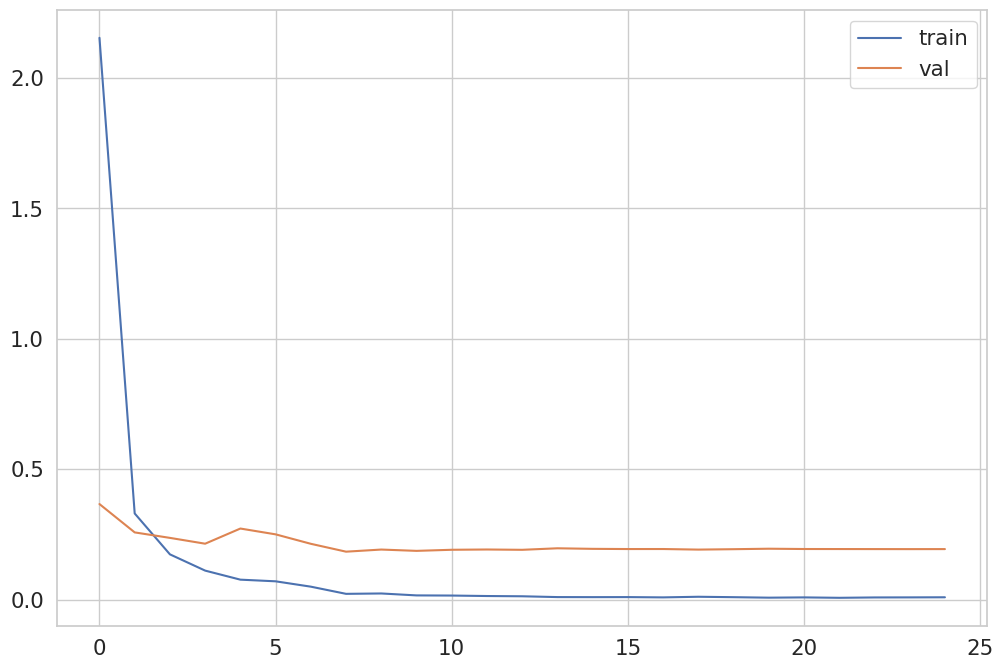

In [ ]:
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.4)

# Построим график лосса при обучении и валидации

#Ваш код здесь
plt.figure(figsize=(12, 8))
plt.plot(losses['train'], label="train")
plt.plot(losses['val'], label="val")
plt.legend()
plt.show()

In [ ]:
torch.save(model.state_dict(), 'AlexNet_fine_tune.pth')
model.load_state_dict(torch.load('AlexNet_fine_tune.pth'))
print("Accuracy: {0:.4f}".format(evaluate(model)))


Accuracy: 0.9610


In [ ]:
def predict(model, test_dataloader):

    logits = []

    with torch.no_grad():
        for data in tqdm(test_dataloader):
            data = data.to(device)
            model.eval()
            outputs = model(data)
            logits.append(outputs)

    return logits

In [ ]:
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=128)

In [ ]:
predictions = predict(model, test_dataloader)

  0%|          | 0/8 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


In [ ]:
preds = nn.functional.softmax(torch.cat(predictions), dim=-1).argmax(-1).cpu().numpy()

In [ ]:
predictions = train_dataset.label_encoder.inverse_transform(preds)
id_lab = [path.name for path in test_files]

In [ ]:
pd.DataFrame({'Id': id_lab, 'Expected': predictions}).to_csv('preds.csv', index=False)